# Stable Diffusion with 🤗 Diffusers

**Pedro Cuenca, Patrick von Platen, Suraj Patil, Jeremy Howard**

Chances are you'll have seen examples in Twitter (and elsewhere) of images generated by typing a short description of the scene you want to create. This is the culmination of years of work in generative models. This notebook introduces Stable Diffusion, the highest-quality open source text to image model as of now. It's also small enough to run in consumer GPUs rather than in a datacenter. We use the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers), which is currently our recommended library for using diffusion models.

As we'll see during the course, understanding state-of-the-art generative models requires a deep understanding of many of the fundamental blocks in modern machine learning models. This notebook shows what Stable Diffusion can do and a glimpse of its main components.

_If you open this notebook in Colab, please uncomment and run the following cell. If you get type errors when generating your first image, please try to upgrade your transformers installation using `pip install --upgrade transformers`_

In [3]:
!pip install diffusers transformers fastcore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.5 MB/s eta 0:00:00


In [38]:
!pip install fastdownload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Using Stable Diffusion

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [12]:
from PIL import Image
from fastcore.all import concat
import torch, logging
from pathlib import Path
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

### Stable Diffusion Pipeline

[`StableDiffusionPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion#diffusers.StableDiffusionPipeline) is an end-to-end [diffusion inference pipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion) that allows you to start generating images with just a few lines of code. Many Hugging Face libraries (along with other libraries such as scikit-learn) use the concept of a "pipeline" to indicate a sequence of steps that when combined complete some task. We'll look at the individual steps of the pipeline later -- for now though, let's just use it to see what it can do.

When we say "inference" we're referring to using an existing model to generate samples (in this case, images), as opposed to "training" (or fine-tuning) models using new data.

We use [`from_pretrained`](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline.from_pretrained) to create the pipeline and download the pretrained weights. We indicate that we want to use the `fp16` (half-precision) version of the weights, and we tell `diffusers` to expect the weights in that format. This allows us to perform much faster inference with almost no discernible difference in quality. The string passed to `from_pretrained` in this case (`CompVis/stable-diffusion-v1-4`) is the repo id of a pretrained pipeline hosted on [Hugging Face Hub](https://huggingface.co/models); it can also be a path to a directory containing pipeline weights. The weights for all the models in the pipeline will be downloaded and cached the first time you run this cell.

In [22]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


The weights are cached in your home directory by default.

In [ ]:
!ls /home/ubuntu/.cache/huggingface/hub

We are now ready to use the pipeline to start creating images.

In [ ]:
prompt = "A detailed picture of a dog in a spacesuit standing on the surface of mars next to a spaceship"

In [ ]:
imgs = pipe(prompt, num_images_per_prompt= 7).images

In [ ]:
imgs[5]

In [ ]:
torch.manual_seed(309)
imgs = pipe(prompt, num_images_per_prompt= 7).images

In [ ]:
imgs[4]

You will have noticed that running the pipeline shows a progress bar with a certain number of steps. This is because Stable Diffusion is based on a progressive denoising algorithm that is able to create a convincing image starting from pure random noise. Models in this family are known as _diffusion models_. Here's an example of the process (from random noise at top to progressively improved images towards the bottom) of a model drawing handwritten digits, which we'll build from scratch ourselves later in the course.

In [ ]:
torch.manual_seed(309)
pipe(prompt, num_images_per_prompt= 7, num_inference_steps=3).images[4]

In [ ]:
torch.manual_seed(309)
pipe(prompt, num_images_per_prompt= 7, num_inference_steps=16).images[4]

### Classifier-Free Guidance

In [ ]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

_Classifier-Free Guidance_ is a method to increase the adherence of the output to the conditioning signal we used (the text).

Roughly speaking, the larger the guidance the more the model tries to represent the text prompt. However, large values tend to produce less diversity. The default is `7.5`, which represents a good compromise between variety and fidelity. This [blog post](https://benanne.github.io/2022/05/26/guidance.html) goes into deeper details on how it works.

We can generate multiple images for the same prompt by simply passing a list of prompts instead of a string.

In [ ]:
num_rows,num_cols = 4,4
prompts = [prompt] * num_cols
images = concat(pipe(prompts, guidance_scale=g).images for g in [1.1,3,7,14])

In [ ]:
image_grid(images, rows=num_rows, cols=num_cols)

### Negative prompts

_Negative prompting_ refers to the use of another prompt (instead of a completely unconditioned generation), and scaling the difference between generations of that prompt and the conditioned generation.

In [ ]:
torch.manual_seed(737)
prompt = "mechanical owl, amber, mettalic colours, cyberpunk , highly detailed, digital art, sharp focus, trending on art station , 8k"
pipe(prompt).images[0]

In [ ]:
torch.manual_seed(737)
pipe(prompt, negative_prompt="mechanical").images[0]

By using the negative prompt we move more towards the direction of the positive prompt, effectively reducing the importance of the negative prompt in our composition.

### Image to Image

Even though Stable Diffusion was trained to generate images, and optionally drive the generation using text conditioning, we can use the raw image diffusion process for other tasks.

For example, instead of starting from pure noise, we can start from an image an add a certain amount of noise to it. We are replacing the initial steps of the denoising and pretending our image is what the algorithm came up with. Then we continue the diffusion process from that state as usual.

This usually preserves the composition although details may change a lot. It's great for sketches!

These operations (provide an initial image, add some noise to it and run diffusion from there) can be automatically performed by a special image to image pipeline: `StableDiffusionImg2ImgPipeline`. This is the source code for its [`__call__` method](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py#L124).

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload

pipei2i = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

We'll use as an example the following sketch created by [user VigilanteRogue81](https://huggingface.co/spaces/huggingface-projects/diffuse-the-rest/discussions/204).

In [ ]:
p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
init_image = Image.open(p).convert("RGB")
init_image

In [ ]:
torch.manual_seed(111)
prompt = "Dog staring at the moon, photorealistic 4K"
images = pipei2i(prompt=prompt, num_images_per_prompt=3, image=init_image, strength=0.8, num_inference_steps=50).images
image_grid(images, rows=1, cols=3)

When we get a composition we like we can use it as the next seed for another prompt and further change the results. For example, let's take the second image above and try to use it to generate something in the style of Van Gogh.

In [ ]:
init_image = images[1]

In [ ]:
torch.manual_seed(1000)
prompt = "Oil painting of dog staring at the moon by Van Gogh"
images = pipei2i(prompt=prompt, num_images_per_prompt=3, image=init_image, strength=0.8, num_inference_steps=70).images
image_grid(images, rows=1, cols=3)

Creative people use different tools in a process of iterative refinement to come up with the ideas they have in mind. Here's a [list with some suggestions](https://github.com/fastai/diffusion-nbs/blob/43a090286e5742f807d4ff58524c02a1888b3004/suggested_tools.md) to get started. 

### Fine-tuning

[How we made the text-to-pokemon model at Lambda](https://lambdalabs.com/blog/how-to-fine-tune-stable-diffusion-how-we-made-the-text-to-pokemon-model-at-lambda/)

![](https://lambdalabs.com/blog/content/images/2022/09/image.png)

Girl with a pearl earring, Cute Obama creature, Donald Trump, Boris Johnson, Totoro, Hello Kitty

### Textual Inversion

Textual inversion is a process where you can quickly "teach" a new word to the text model and plain its embeddings close to some visual representation. This is achieved by adding a new token to the vocabulary, freezing the weights of all the models (except the text encoder), and train with a few representative images.

This is a schematic representation of the process by the [authors of the paper](https://textual-inversion.github.io).

![Textual Inversion diagram](https://textual-inversion.github.io/static/images/training/training.JPG)

---

You can train your own tokens with photos you provide using [this training script](https://github.com/huggingface/diffusers/tree/main/examples/textual_inversion) or [Google Colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb). There's also a [Colab notebook for inference](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb), but we'll show below the steps we have to follow to add a trained token to the vocabulary and make it work the pre-trained Stable Diffusion model.

We'll try an example using embeddings trained for [this style](https://huggingface.co/sd-concepts-library/midjourney-style).

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16) 
pipe = pipe.to("cuda")

In [ ]:
embeds_url = "https://huggingface.co/sd-concepts-library/midjourney-style/resolve/main/learned_embeds.bin"
embeds_path = FastDownload().download(embeds_url)
embeds_dict = torch.load(str(embeds_path), map_location="cpu")

The embeddings for the new token are stored in a small PyTorch pickled dictionary, whose key is the new text token that was trained. Since the encoder of our pipeline does not know about this term, we need to manually append it.

In [ ]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
new_token, embeds = next(iter(embeds_dict.items()))
embeds = embeds.to(text_encoder.dtype)
new_token

We add the new token to the tokenizer and the trained embeddings to the embeddings table.

In [ ]:

assert tokenizer.add_tokens(new_token) == 1, "The token already exists!"

In [ ]:
text_encoder.get_input_embeddings().weight.data.shape

In [ ]:
len(tokenizer)

In [ ]:
embeds.shape

In [ ]:
text_encoder.resize_token_embeddings(len(tokenizer))
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
text_encoder.get_input_embeddings().weight.data[new_token_id] = embeds

We can now run inference and refer to the style as if it was another word in the dictionary.

In [ ]:
torch.manual_seed(104)
image = pipe("Elephant on the moon in the style of <midjourney-style>").images[0]
image

### Dreambooth

[Dreambooth](https://dreambooth.github.io) is a kind of fine-tuning that attempts to introduce new subjects by providing just a few images of the new subject. The goal is similar to that of [Textual Inversion](#Textual-Inversion), but the process is different. Instead of creating a new token as Textual Inversion does, we select an existing token in the vocabulary (usually a rarely used one), and fine-tune the model for a few hundred steps to bring that token close to the images we provide. This is a regular fine-tuning process in which all modules are unfrozen.

We will be using `sd-dreambooth-library/fashion` for the following example

In [ ]:
db_pipe = StableDiffusionPipeline.from_pretrained("sd-dreambooth-library/fashion", torch_dtype=torch.float16)
db_pipe = db_pipe.to("cuda")

In [ ]:
torch.manual_seed(1000)

prompt = "a photograph of a person going for work in intergalactic route in a spaceship"
images = db_pipe(prompt, num_images_per_prompt=4).images
image_grid(images, 1, 4)

Fine-tuning with Dreambooth is finicky and sensitive to hyperparameters, as we are essentially asking the model to overfit the prompt to the supplied images. In some situations we observe problems such as catastrophic forgetting of the associated term The authors applied a technique called "prior preservation" to try to avoid it by performing a special regularization using other examples of the term, in addition to the ones we provided. The cool thing about this idea is that those examples can be easily generated by the pre-trained Stable Diffusion model itself! We did not use that method in the model we trained for the previous example.

Other ideas that may work include: use EMA so that the final weights preserve some of the previous knowledge, use progressive learning rates for fine-tuning, or combine the best of Textual Inversion with Dreambooth. These could make for some interesting projects to try out!

If you want to train your own Dreambooth model, you can use [this script](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth) or [this Colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb). 

### What is Stable Diffusion

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

### Latents and callbacks

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.** 

The Stable Diffusion pipeline can send intermediate latents to a callback function we provide. By running these latents through the image decoder (the `vae` component of the pipeline), we can see how the denoising process progresses and the image unfolds.

In [6]:
vae = pipe.vae
images = []

def latents_callback(i, t, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(1, 2, 0).numpy()
    images.extend(pipe.numpy_to_pil(image))

prompt = "Portrait painting of Jeremy Howard looking happy."
torch.manual_seed(1000)
final_image = pipe(prompt, callback=latents_callback, callback_steps=12).images[0]
images.append(final_image)
image_grid(images, rows=1, cols=len(images))

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: ignored

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8 but uses 4 channels instead of 3. This means that an image of shape `(3, 512, 512)` becomes `(4, 64, 64)` in latent space, which requires `8 × 8 × 3/4 = 48` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

## Looking inside the pipeline

The inference pipeline is just a small piece of code that plugs the components together and performs the inference loop. [This is all there it to is](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L204).

We'll go through the process of loading and plugging the pieces to see how we could have written it ourselves. We'll start by loading all the modules that we need from their pretrained weights.

First, we need the text encoder and the tokenizer. These come from the text portion of a standard CLIP model, so we'll use the weights released by Open AI.

In [7]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

Next we'll load the `vae` and the `unet`. These are distinct models whose weights are stored inside folders of the Stable Diffusion repository. We can use the `subfolder` argument to refer to [these locations](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/main).

In [8]:
from diffusers import AutoencoderKL, UNet2DConditionModel

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

Next we move the models to the GPU.

In [9]:
vae = vae.to("cuda")
text_encoder = text_encoder.to("cuda")
unet = unet.to("cuda") 

To make things a bit different, we'll use another scheduler. The standard pipeline uses the [PNDM Scheduler](https://arxiv.org/abs/2202.09778), but we'll use [Katherine Crowson's](https://github.com/crowsonkb) excellent K-LMS scheduler.

We need to be careful to use the same noising schedule that was used during training. The schedule is defined by the number of noising steps and the amount of noise added at each step, which is derived from the _beta_ parameters.

In the case of the k-LMS scheduler, this is how the betas evolve during the 1000 steps of the noising process used during training:

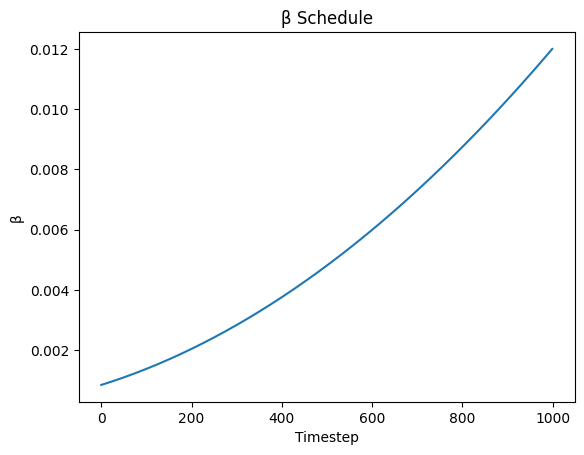

In [10]:
beta_start = 0.00085
beta_end = 0.012
betas = torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2

plt.plot(betas)
plt.title('β Schedule')
plt.xlabel('Timestep')
plt.ylabel('β')
plt.show()

In [11]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

We now define the parameters we'll use for generation.

In contrast with the previous examples, we set `num_inference_steps` to 70 to get an even more defined image.

In [12]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

We tokenize the prompt. The model requires the same number of tokens for every prompt, so padding is used to ensure we meet the required length.

In [13]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids']

tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

In [14]:
tokenizer.decode(49407)

'<|endoftext|>'

The attention mask uses zero to represent tokens we are not interested in. These are all of the padding tokens.

In [15]:
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

The text encoder gives us the embeddings for the text prompt we used.

In [16]:
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]
text_embeddings.shape

torch.Size([1, 77, 768])

We also get the embeddings required to perform unconditional generation, which is achieved with an empty string: the model is free to go in whichever direction it wants as long as it results in a reasonably-looking image. These embeddings will be applied to apply classifier-free guidance.

In [17]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]
uncond_embeddings.shape

torch.Size([1, 77, 768])

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [18]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

To start the denoising process, we start from pure Gaussian (normal) noise. These are our initial latents.

In [19]:
torch.manual_seed(100)
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda")
latents.shape

<ipython-input-19-540b2a02b43f>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))


torch.Size([1, 4, 64, 64])

`4×64×64` is the input shape. The decoder will later transform this latent representation into a `3×512×512` image after the denoising process is complete.

Next, we initialize the scheduler with our chosen `num_inference_steps`. This will prepare the internal state to be used during denoising.

In [20]:
scheduler.set_timesteps(num_inference_steps)

We scale the initial noise by the standard deviation required by the scheduler. This value will depend on the particular scheduler we use.

In [21]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop. The timesteps go from `999` to `0` (1000 steps that were used during training) following a particular schedule.

In [22]:
scheduler.timesteps

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3043, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9130, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0870, 260.6087, 246.1304, 231.6522, 217.1739, 202.6957,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3043, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000],
       dtype=torch.float64)

In [23]:
scheduler.sigmas

tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7477,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

In [26]:
from tqdm.auto import tqdm

for i, t in enumerate(tqdm(scheduler.timesteps)):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

After this process complets our `latents` contain the denoised representation of the image. We use the `vae` decoder to convert it back to pixel space.

In [27]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

And finally, let's convert the image to PIL so we can display it.

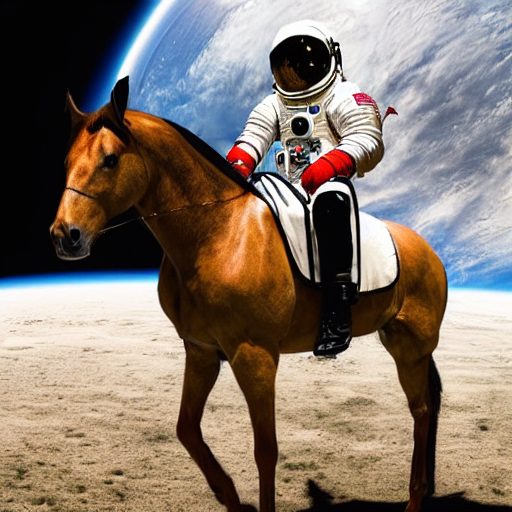

In [28]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

## Combine all above steps - negative prompting

In [16]:
from tqdm.auto import tqdm
from PIL import Image

In [17]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

vae = vae.to("cuda")
text_encoder = text_encoder.to("cuda")
unet = unet.to("cuda") 

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [34]:
torch.manual_seed(737)

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

prompt = ["mechanical owl, amber, mettalic colours, cyberpunk , highly detailed, digital art, sharp focus, trending on art station , 8k"]
negative_prompt = ["mechanical"]

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]

max_length = text_input.input_ids.shape[-1]
if negative_prompt:
  uncond_input = tokenizer(negative_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
else:
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]
uncond_embeddings.shape


text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda")

scheduler.set_timesteps(num_inference_steps)

latents = latents * scheduler.init_noise_sigma


for i, t in enumerate(tqdm(scheduler.timesteps)):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


  

<ipython-input-34-f9588cef7df8>:28: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))


  0%|          | 0/70 [00:00<?, ?it/s]

In [35]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

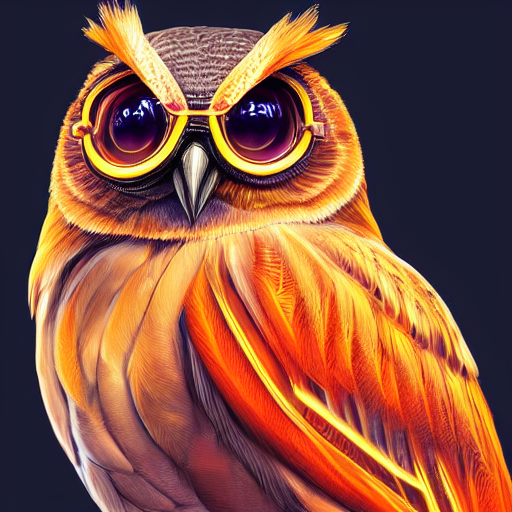

In [36]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]